In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
from tools import *
from methods import generalized_eig_extract, solve_scale_shift, solve_scale_shift_ab
import matplotlib.pyplot as plt
set_seaborn()

In [5]:
# set params
dim = 20
time = np.arange(0, 3, 0.001)
num_init = 20
init_var = 10 
iterations = np.arange(100)

a_s = np.array([4, 3.5, 0.6, 0.0475, 0.05 ])
# e_s = np.array([-5, -1.5, 0, 1.5, 5.001])
e_s = np.array([-1.5, -1, 0, 1, 1.501])

In [6]:
def learn_filter_from_inits(T_series, dim, shift=1):
    X0Xps = []
    X0X0s = []
    for i, t_series in enumerate(T_series):
        # build a series with some random initial conditons and noise
        han = build_hankel(t_series, dim)
        # compute coverances and avgerage
        X0 = han[:, :-shift]
        Xp = han[:, shift:]
        X0Xps.append(X0 @ Xp.T)
        X0X0s.append(X0 @ X0.T)
    # take means and compute top left eig vector 
    X0X0 = np.mean(X0X0s, axis=0)
    X0Xp = np.mean(X0Xps, axis=0)
    w, vl = scipy.linalg.eig(X0Xp, X0X0)
    sortorder = np.flip(np.argsort(w.real))
    w = w[sortorder]
    w = np.sort(np.real_if_close(w))[::-1]
    vl = vl[:, sortorder]
    theta = vl[:, 0]
    return theta
    

In [7]:
def build_exp_series_too(a_s, e_s, noise=0.0, time=np.arange(0, 3, 0.1)):
    components = []
    X = np.zeros_like(time)
    for i in range(len(e_s)):
        c = exp_f(time, e_s[i], a_s[i])
        c = c.real
        X += c
        components.append(c)

    X += noise * np.random.randn(len(X))
    y_i = np.argmax(np.abs(e_s.real))
    Y = components[y_i]

    return X, Y, time, components

In [13]:
def solve_scale_shift_ab(P_series, Y_series):
    P_series_1 = P_series
    # P_series_1 = np.vstack((P_series, np.ones(len(P_series))))
    ab = (Y_series @ P_series_1.T) /((P_series_1 @ P_series_1.T))
    # a, b = ab[0], ab[1]

    return ab


def solve_scale_shift(P_series, Y_series):
    P_series_1 = P_series
    # P_series_1 = np.vstack((P_series, np.ones(len(P_series))))
    ab = (Y_series @ P_series_1.T) /((P_series_1 @ P_series_1.T))
    # a, b = ab[0], ab[1]
    P_series = P_series*ab

    return P_series

In [42]:
init_var = 0
dim = 20


time = np.arange(0, 3, 0.01)

noise = 0.001
thetas = []
thetas_opt = []
P_series_s = []
P_series_s_opt = []
T_series_s = []
# generate X_series and Y_series
X_series, Y_series, _, components = build_exp_series_too(a_s, e_s, noise=noise, time=time)
Y_series = Y_series[dim:]
X_series_nf = np.sum(components,axis=0)
Xhan = build_hankel(X_series, dim)
Xhan_nf = build_hankel(X_series_nf, dim)


t_series_noise_free = X_series_nf + 0.000001*np.random.randn(len(X_series_nf))

for itr in iterations[:1]:
    # build inital conditions by pertubing target inital conditions
    inits = np.tile(a_s, (num_init, 1)) 
    inits *= (1+init_var * np.random.randn(*inits.shape))

    # build training series with some random initial conditons and noise
    T_series = []
    # for i,init in enumerate(inits):
    t_series, _, _, comps = build_exp_series_too(inits[0], e_s, noise=noise, time=time)
    T_series = [t_series]
    T_series_s = [t_series]

    theta = learn_filter_from_inits(T_series, dim)
    theta_nf = learn_filter_from_inits([t_series_noise_free], dim)
    P_series_nf = theta_nf.real @ Xhan_nf
    a = solve_scale_shift_ab(P_series_nf, Y_series)
    theta_nf = a*theta_nf.real
    P_series_nf = theta_nf @ Xhan_nf
    # P_series_nf *= np.sign(P_series_nf[-1])*np.sign(Y_series)
    

    han = build_hankel(np.sum(comps, axis=0), dim)
    # compute coverances and avgerage
    X0 = han[:, :]
    Cxx = X0 @ X0.T / X0.shape[1]

    theta_opt = np.linalg.inv(Cxx + noise**2*np.eye(dim))@Cxx@theta_nf


    # ALGO


    P_series = theta.real @ Xhan
    P_series = solve_scale_shift(P_series, Y_series)
    # P_series *= np.sign(P_series[-1])*np.sign(Y_series)

    P_series_opt = theta_opt.real @ Xhan
    P_series_opt = solve_scale_shift(P_series_opt, Y_series)
    # P_series_opt *= np.sign(P_series_opt[-1])*np.sign(Y_series)


    P_series_nf_on_noisy = theta_nf.real @ Xhan
    P_series_nf_on_noisy = solve_scale_shift(P_series_nf_on_noisy, Y_series)
    P_series_nf_on_noisy *= np.sign(P_series_nf_on_noisy[-1])*np.sign(Y_series)

    theta /= theta[-1]
    theta_opt /= theta_opt[-1]

    thetas.append(theta.real)
    thetas_opt.append(theta_opt.real)
    P_series_s.append(P_series)
    P_series_s_opt.append(P_series_opt)


plt.locator_params(axis='y', nbins=5)

# solution plot
p_mean, p_std = np.mean(P_series_s, axis=0), np.std(P_series_s, axis=0)
p_mean_opt, p_std_opt = np.mean(P_series_s_opt, axis=0), np.std(P_series_s_opt, axis=0)
p_time = time[dim:]
plt.plot(p_time, p_mean, '-', label='Extracted')
plt.fill_between(p_time, p_mean-p_std, p_mean+p_std, alpha=0.2)
plt.plot(p_time, p_mean_opt, '-', label='Extracted_opt')
plt.fill_between(p_time, p_mean_opt-p_std_opt, p_mean_opt+p_std_opt, alpha=0.2)
# plt.plot(p_time, Y_series, '*', label='True')
plt.plot(p_time, P_series_nf, '-', label='Extracted_nf')
# plt.plot(p_time, P_series_nf_on_noisy, '-', label='Extracted_nf_on_noisy')
plt.legend(frameon=False)
plt.text(-.08, 1.03, 'D', fontweight='bold', fontsize='28', transform=plt.gca().transAxes)
plt.yticks([0,2,4])
sns.despine(offset = 10)
plt.title('Extracted time sereis', fontsize=14, pad = 15)
plt.tight_layout()
plt.savefig('extractedseries_comparison.pdf')
plt.show()

ESS = [np.mean((Y_series - p)**2) for p in P_series_s]
David = [np.mean((Y_series - p)**2) for p in P_series_s_opt]
print('ESS = ', np.mean(ESS), np.std(ESS))
print('David = ', np.mean(David), np.std(David))
print('NF_on_noisy = ', np.mean((Y_series - P_series_nf_on_noisy)**2))
print('NF_on_NF = ', np.mean((Y_series - P_series_nf)**2))




ESS =  0.021269405172826036 0.0
David =  0.0021608557969910944 0.0
NF_on_noisy =  0.5411133801858672
NF_on_NF =  0.0005742067414841658


In [89]:
ESS = [np.mean((P_series_nf - p)**2) for p in P_series_s]
David = [np.mean((P_series_nf - p)**2) for p in P_series_s_opt]
print('ESS = ', np.mean(ESS), np.std(ESS))
print('David = ', np.mean(David), np.std(David))

ESS =  0.002175540022843601 0.0
David =  0.008715782689284381 0.0


In [53]:
init_var = 0
dim = 20


time = np.arange(0, 3, 0.05)


ESS_errors = []
David_errors = []
NF_on_noisy_errors = []
ESS_STDs = []
David_STDs = []
NF_on_noisy_STDs = []

noises = np.logspace(np.log10(0.0001),np.log10(3),15)
a_scales= []
# noises = [0.001]

for noise in noises:


    thetas = []
    thetas_opt = []
    P_series_s = []
    P_series_s_opt = []
    P_series_s_nf_on_noisy = []
    T_series_s = []
    a_scales.append([])
    # generate X_series and Y_series
    # X_series, Y_series, _, components = build_exp_series_too(a_s, e_s, noise=noise, time=time)
    # Y_series = Y_series[dim:]
    # X_series_nf = np.sum(components,axis=0)
    # Xhan = build_hankel(X_series, dim)
    # Xhan_nf = build_hankel(X_series_nf, dim)

    for itr in iterations:
        # build inital conditions by pertubing target inital conditions
        inits = np.tile(a_s, (num_init, 1)) 
        # inits *= (1+init_var * np.random.randn(*inits.shape))

        # build training series with some random initial conditons and noise
        T_series = []
        # for i,init in enumerate(inits):
        t_series, _, _, comps = build_exp_series_too(inits[0], e_s, noise=noise, time=time)
        T_series = [t_series]
        T_series_s = [t_series]

        theta = learn_filter_from_inits(T_series, dim)
        theta_nf = learn_filter_from_inits([t_series_noise_free], dim)

        han = build_hankel(np.sum(comps, axis=0), dim)
        # compute coverances and avgerage
        X0 = han[:, :]
        Cxx = X0 @ X0.T /X0.shape[1]

        theta_opt = np.linalg.inv(Cxx + noise**2*np.eye(dim))@Cxx@theta_nf


        # ALGO


        X_series, Y_series, _, components = build_exp_series_too(a_s, e_s, noise=noise, time=time)
        Y_series = Y_series[dim:]
        X_series_nf = np.sum(components,axis=0)
        t_series_noise_free = X_series_nf + 0.00001*np.random.randn(len(X_series_nf))
        Xhan = build_hankel(X_series, dim)
        Xhan_nf = build_hankel(X_series_nf, dim)


        P_series = theta.real @ Xhan
        a_scales[-1].append(np.abs(solve_scale_shift_ab(P_series, Y_series)))
        P_series = solve_scale_shift(P_series, Y_series)
        # P_series *= np.sign(P_series[-1])*np.sign(Y_series)

        P_series_opt = theta_opt.real @ Xhan
        P_series_opt = solve_scale_shift(P_series_opt, Y_series)
        # P_series_opt *= np.sign(P_series_opt[-1])*np.sign(Y_series)

        P_series_nf = theta_nf.real @ Xhan_nf
        P_series_nf = solve_scale_shift(P_series_nf, Y_series)
        # P_series_nf *= np.sign(P_series_nf[-1])*np.sign(Y_series)

        P_series_nf_on_noisy = theta_nf.real @ Xhan
        P_series_nf_on_noisy = solve_scale_shift(P_series_nf_on_noisy, Y_series)
        # P_series_nf_on_noisy *= np.sign(P_series_nf_on_noisy[-1])*np.sign(Y_series)

        theta /= theta[-1]
        theta_opt /= theta_opt[-1]

        thetas.append(theta.real)
        thetas_opt.append(theta_opt.real)
        P_series_s.append(P_series)
        P_series_s_opt.append(P_series_opt)
        P_series_s_nf_on_noisy.append(P_series_nf_on_noisy)


    ESS = [np.mean((Y_series - p)**2) for p in P_series_s]
    David = [np.mean((Y_series - p)**2) for p in P_series_s_opt]
    nf_on_noisy = [np.mean((Y_series - p)**2) for p in P_series_s_nf_on_noisy]

    ESS_errors.append(np.mean(ESS))
    ESS_STDs.append(np.std(ESS))

    David_errors.append(np.mean(David))
    David_STDs.append(np.std(David))

    NF_on_noisy_errors.append(np.mean(nf_on_noisy))
    NF_on_noisy_STDs.append(np.std(nf_on_noisy))

    # print('ESS = ', np.mean(ESS), np.std(ESS))
    # print('David = ', np.mean(David), np.std(David))
    # print('NF_on_noisy = ', np.sum((Y_series - P_series_nf_on_noisy)**2))
    # print('NF_on_NF = ', np.sum((Y_series - P_series_nf)**2))

ESS_errors, ESS_STDs, David_errors, David_STDs, NF_on_noisy_errors, NF_on_noisy_STDs = (np.array(el) for el in [ESS_errors, ESS_STDs, David_errors, David_STDs, NF_on_noisy_errors, NF_on_noisy_STDs])

plt.plot(noises,ESS_errors,'.-',label='ours')
plt.fill_between(noises, ESS_errors-ESS_STDs, ESS_errors+ESS_STDs, alpha=0.2)
plt.plot(noises,David_errors,'.-', label='noise optimal')
plt.fill_between(noises, David_errors-David_STDs, David_errors+David_STDs, alpha=0.2)
plt.plot(noises,NF_on_noisy_errors,'.-', label='noiseless filter')
plt.fill_between(noises, NF_on_noisy_errors-NF_on_noisy_STDs, NF_on_noisy_errors+NF_on_noisy_STDs, alpha=0.2)
# plt.plot([noises[0],noises[-1]],[noises[0],noises[-1]], c='k', dashes=[15,9], lw=.3)
plt.legend(loc=4)

plt.xscale('log')
plt.yscale('log')


# plt.xticks(lag_i, ['$t - {}$'.format(abs(el)) for el in lag_i[:-1]]+['$t$'])
sns.despine(offset = 10)
plt.xlabel('noise', fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.tight_layout()
plt.savefig('comp2david.pdf')

plt.show()

In [61]:
init_var = 0
dim = 10


time = np.arange(0, 3, 0.01)


ESS_errors = []
David_errors = []
NF_on_noisy_errors = []
ESS_STDs = []
David_STDs = []
NF_on_noisy_STDs = []

noises = np.logspace(np.log10(0.0001),np.log10(3),15)
a_scales= []
a_scales_nf = []
a_scales_opt = []
# noises = [0.001]

for noise in noises:


    thetas = []
    thetas_opt = []
    P_series_s = []
    P_series_s_opt = []
    P_series_s_nf_on_noisy = []
    T_series_s = []
    a_scales.append([])
    a_scales_opt.append([])
    a_scales_nf.append([])
    # generate X_series and Y_series
    # X_series, Y_series, _, components = build_exp_series_too(a_s, e_s, noise=noise, time=time)
    # Y_series = Y_series[dim:]
    # X_series_nf = np.sum(components,axis=0)
    # Xhan = build_hankel(X_series, dim)
    # Xhan_nf = build_hankel(X_series_nf, dim)

    for itr in iterations:
        # build inital conditions by pertubing target inital conditions
        inits = np.tile(a_s, (num_init, 1)) 
        # inits *= (1+init_var * np.random.randn(*inits.shape))

        # build training series with some random initial conditons and noise
        T_series = []
        # for i,init in enumerate(inits):
        t_series, _, _, comps = build_exp_series_too(inits[0], e_s, noise=noise, time=time)
        T_series = [t_series]
        T_series_s = [t_series]

        theta = learn_filter_from_inits(T_series, dim)
        theta_nf = learn_filter_from_inits([t_series_noise_free], dim)

        han = build_hankel(np.sum(comps, axis=0), dim)
        # compute coverances and avgerage
        X0 = han[:, :]
        Cxx = X0 @ X0.T /X0.shape[1]

        theta_opt = np.linalg.inv(Cxx + noise**2*np.eye(dim))@Cxx@theta_nf


        # ALGO


        X_series, Y_series, _, components = build_exp_series_too(a_s, e_s, noise=noise, time=time)
        Y_series = Y_series[dim:]
        X_series_nf = np.sum(components,axis=0)
        t_series_noise_free = X_series_nf + 0.00001*np.random.randn(len(X_series_nf))
        Xhan = build_hankel(X_series, dim)
        Xhan_nf = build_hankel(X_series_nf, dim)


        P_series = theta.real @ Xhan
        a_scales[-1].append(np.abs(solve_scale_shift_ab(P_series, Y_series)))
        P_series = solve_scale_shift(P_series, Y_series)
        # P_series *= np.sign(P_series[-1])*np.sign(Y_series)

        P_series_opt = theta_opt.real @ Xhan
        a_scales_opt[-1].append(np.abs(solve_scale_shift_ab(P_series_opt, Y_series)))
        P_series_opt = solve_scale_shift(P_series_opt, Y_series)
        # P_series_opt *= np.sign(P_series_opt[-1])*np.sign(Y_series)

        P_series_nf = theta_nf.real @ Xhan_nf
        P_series_nf = solve_scale_shift(P_series_nf, Y_series)
        # P_series_nf *= np.sign(P_series_nf[-1])*np.sign(Y_series)

        P_series_nf_on_noisy = theta_nf.real @ Xhan
        a_scales_nf[-1].append(np.abs(solve_scale_shift_ab(P_series_nf_on_noisy, Y_series)))
        P_series_nf_on_noisy = solve_scale_shift(P_series_nf_on_noisy, Y_series)
        # P_series_nf_on_noisy *= np.sign(P_series_nf_on_noisy[-1])*np.sign(Y_series)

        theta /= theta[-1]
        theta_opt /= theta_opt[-1]

        thetas.append(theta.real)
        thetas_opt.append(theta_opt.real)
        P_series_s.append(P_series)
        P_series_s_opt.append(P_series_opt)
        P_series_s_nf_on_noisy.append(P_series_nf_on_noisy)


    ESS = [np.mean((Y_series - p)**2) for p in P_series_s]
    David = [np.mean((Y_series - p)**2) for p in P_series_s_opt]
    nf_on_noisy = [np.mean((Y_series - p)**2) for p in P_series_s_nf_on_noisy]

    ESS_errors.append(np.mean(ESS))
    ESS_STDs.append(np.std(ESS))

    David_errors.append(np.mean(David))
    David_STDs.append(np.std(David))

    NF_on_noisy_errors.append(np.mean(nf_on_noisy))
    NF_on_noisy_STDs.append(np.std(nf_on_noisy))

    # print('ESS = ', np.mean(ESS), np.std(ESS))
    # print('David = ', np.mean(David), np.std(David))
    # print('NF_on_noisy = ', np.sum((Y_series - P_series_nf_on_noisy)**2))
    # print('NF_on_NF = ', np.sum((Y_series - P_series_nf)**2))

ESS_errors, ESS_STDs, David_errors, David_STDs, NF_on_noisy_errors, NF_on_noisy_STDs = (np.array(el) for el in [ESS_errors, ESS_STDs, David_errors, David_STDs, NF_on_noisy_errors, NF_on_noisy_STDs])

plt.plot(noises,ESS_errors,'.-',label='ours')
plt.fill_between(noises, ESS_errors-ESS_STDs, ESS_errors+ESS_STDs, alpha=0.2)
plt.plot(noises,David_errors,'.-', label='noise optimal')
plt.fill_between(noises, David_errors-David_STDs, David_errors+David_STDs, alpha=0.2)
plt.plot(noises,NF_on_noisy_errors,'.-', label='noiseless filter')
plt.fill_between(noises, NF_on_noisy_errors-NF_on_noisy_STDs, NF_on_noisy_errors+NF_on_noisy_STDs, alpha=0.2)
# plt.plot([noises[0],noises[-1]],[noises[0],noises[-1]], c='k', dashes=[15,9], lw=.3)
plt.legend(loc=4)

plt.xscale('log')
plt.yscale('log')


# plt.xticks(lag_i, ['$t - {}$'.format(abs(el)) for el in lag_i[:-1]]+['$t$'])
sns.despine(offset = 10)
plt.xlabel('noise', fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.tight_layout()
plt.savefig('comp2david.pdf')

plt.show()

In [69]:
init_var = 0
dim = 10


time = np.arange(0, 3, 0.01)


ESS_errors = []
David_errors = []
NF_on_noisy_errors = []
ESS_errors_log = []
David_errors_log = []
NF_on_noisy_errors_log = []
ESS_STDs = []
David_STDs = []
NF_on_noisy_STDs = []
ESS_STDs_log = []
David_STDs_log = []
NF_on_noisy_STDs_log = []

noises = np.logspace(np.log10(0.0001),np.log10(3),15)
# noises = [0.001]

for noise,a_scale, a_scale_opt, a_scale_nf in zip(noises,a_scales, a_scales_opt, a_scales_nf):


    thetas = []
    thetas_opt = []
    P_series_s = []
    P_series_s_opt = []
    P_series_s_nf_on_noisy = []
    T_series_s = []
    # generate X_series and Y_series
    # X_series, Y_series, _, components = build_exp_series_too(a_s, e_s, noise=noise, time=time)
    # Y_series = Y_series[dim:]
    # X_series_nf = np.sum(components,axis=0)
    # Xhan = build_hankel(X_series, dim)
    # Xhan_nf = build_hankel(X_series_nf, dim)

    for itr in iterations:
        # build inital conditions by pertubing target inital conditions
        inits = np.tile(a_s, (num_init, 1)) 
        # inits *= (1+init_var * np.random.randn(*inits.shape))

        # build training series with some random initial conditons and noise
        T_series = []
        # for i,init in enumerate(inits):
        t_series, _, _, comps = build_exp_series_too(inits[0], e_s, noise=noise, time=time)
        T_series = [t_series]
        T_series_s = [t_series]

        theta = learn_filter_from_inits(T_series, dim)
        theta_nf = learn_filter_from_inits([t_series_noise_free], dim)

        han = build_hankel(np.sum(comps, axis=0), dim)
        # compute coverances and avgerage
        X0 = han[:, :]
        Cxx = X0 @ X0.T /X0.shape[1]

        theta_opt = np.linalg.inv(Cxx + noise**2*np.eye(dim))@Cxx@theta_nf


        # ALGO


        X_series, Y_series, _, components = build_exp_series_too(a_s, e_s, noise=noise, time=time)
        Y_series = Y_series[dim:]
        X_series_nf = np.sum(components,axis=0)
        t_series_noise_free = X_series_nf + 0.00001*np.random.randn(len(X_series_nf))
        Xhan = build_hankel(X_series, dim)
        Xhan_nf = build_hankel(X_series_nf, dim)


        P_series = np.mean(a_scale)*theta.real @ Xhan
        # a_scales[-1].append(np.abs(solve_scale_shift_ab(P_series, Y_series)))
        # P_series = solve_scale_shift(P_series, Y_series)
        P_series *= np.sign(P_series[-1])*np.sign(Y_series)

        P_series_opt = np.mean(a_scale_opt)*theta_opt.real @ Xhan
        # P_series_opt = solve_scale_shift(P_series_opt, Y_series)
        P_series_opt *= np.sign(P_series_opt[-1])*np.sign(Y_series)

        P_series_nf = theta_nf.real @ Xhan_nf
        P_series_nf = solve_scale_shift(P_series_nf, Y_series)
        # P_series_nf *= np.sign(P_series_nf[-1])*np.sign(Y_series)

        P_series_nf_on_noisy = np.mean(a_scale_nf)*theta_nf.real @ Xhan
        # P_series_nf_on_noisy = solve_scale_shift(P_series_nf_on_noisy, Y_series)
        P_series_nf_on_noisy *= np.sign(P_series_nf_on_noisy[-1])*np.sign(Y_series)

        theta /= theta[-1]
        theta_opt /= theta_opt[-1]

        thetas.append(theta.real)
        thetas_opt.append(theta_opt.real)
        P_series_s.append(P_series)
        P_series_s_opt.append(P_series_opt)
        P_series_s_nf_on_noisy.append(P_series_nf_on_noisy)


    ESS = [np.mean((Y_series - p)**2) for p in P_series_s]
    David = [np.mean((Y_series - p)**2) for p in P_series_s_opt]
    nf_on_noisy = [np.mean((Y_series - p)**2) for p in P_series_s_nf_on_noisy]

    ESS_errors.append(np.mean(ESS))
    ESS_STDs.append(np.std(ESS))
    ESS_errors_log.append(np.log10(ESS).mean())
    ESS_STDs_log.append(np.log10(ESS).std())

    David_errors.append(np.mean(David))
    David_STDs.append(np.std(David))
    David_errors_log.append(np.log10(David).mean())
    David_STDs_log.append(np.log10(David).std())

    NF_on_noisy_errors.append(np.mean(nf_on_noisy))
    NF_on_noisy_STDs.append(np.std(nf_on_noisy))
    NF_on_noisy_errors_log.append(np.log10(nf_on_noisy).mean())
    NF_on_noisy_STDs_log.append(np.log10(nf_on_noisy).std())

    # print('ESS = ', np.mean(ESS), np.std(ESS))
    # print('David = ', np.mean(David), np.std(David))
    # print('NF_on_noisy = ', np.sum((Y_series - P_series_nf_on_noisy)**2))
    # print('NF_on_NF = ', np.sum((Y_series - P_series_nf)**2))

ESS_errors, ESS_STDs, David_errors, David_STDs, NF_on_noisy_errors, NF_on_noisy_STDs = (np.array(el) for el in [ESS_errors, ESS_STDs, David_errors, David_STDs, NF_on_noisy_errors, NF_on_noisy_STDs])

plt.plot(noises,ESS_errors,'.-',label='ours')
plt.fill_between(noises, ESS_errors-ESS_STDs, ESS_errors+ESS_STDs, alpha=0.2)
plt.plot(noises,David_errors,'.-', label='noise optimal')
plt.fill_between(noises, David_errors-David_STDs, David_errors+David_STDs, alpha=0.2)
plt.plot(noises,NF_on_noisy_errors,'.-', label='non-adaptive')
plt.fill_between(noises, NF_on_noisy_errors-NF_on_noisy_STDs, NF_on_noisy_errors+NF_on_noisy_STDs, alpha=0.2)
# plt.plot([noises[0],noises[-1]],[noises[0],noises[-1]], c='k', dashes=[15,9], lw=.3)
plt.legend(loc=4)

plt.xscale('log')
plt.yscale('log')


# plt.xticks(lag_i, ['$t - {}$'.format(abs(el)) for el in lag_i[:-1]]+['$t$'])
sns.despine(offset = 10)
plt.xlabel('noise', fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.tight_layout()
plt.savefig('comp2david.pdf')

plt.show()

In [72]:
ESS_errors_log

[-1.5879096303122784,
 -1.3234464562962356,
 -1.321744178902662,
 -1.442585727424518,
 -1.4724163297175485,
 -1.4894312238930696,
 -1.4517394381515702,
 -1.317150001606107,
 -0.9051535379234152,
 -0.20996852943147334,
 0.06459943527403211,
 0.10633702672516777,
 0.11768589315228142,
 0.12221888408277007,
 0.13460601879807332]

In [71]:
ESS_errors_log, ESS_STDs_log, David_errors_log, David_STDs_log, NF_on_noisy_errors_log, NF_on_noisy_STDs_log = (np.array(el) for el in [ESS_errors_log, ESS_STDs_log, David_errors_log, David_STDs, NF_on_noisy_errors, NF_on_noisy_STDs])

plt.plot(noises,10**ESS_errors_log,'.-',label='ours')
plt.fill_between(noises, 10**(ESS_errors_log-ESS_STDs_log), 10**(ESS_errors_log+ESS_STDs_log), alpha=0.2)
plt.plot(noises,David_errors,'.-', label='noise optimal')
plt.fill_between(noises, David_errors_log-David_STDs_log, David_errors_log+David_STDs_log, alpha=0.2)
plt.plot(noises,NF_on_noisy_errors_log,'.-', label='non-adaptive')
plt.fill_between(noises, NF_on_noisy_errors_log-NF_on_noisy_STDs_log, NF_on_noisy_errors_log+NF_on_noisy_STDs_log, alpha=0.2)
# plt.plot([noises[0],noises[-1]],[noises[0],noises[-1]], c='k', dashes=[15,9], lw=.3)
plt.legend(loc=4)

plt.xscale('log')
plt.yscale('log')


# plt.xticks(lag_i, ['$t - {}$'.format(abs(el)) for el in lag_i[:-1]]+['$t$'])
sns.despine(offset = 10)
plt.xlabel('noise', fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.tight_layout()
plt.savefig('comp2david.pdf')

plt.show()

TypeError: unsupported operand type(s) for ** or pow(): 'int' and 'list'

In [41]:
init_var = 0
dim = 5


time = np.arange(0, 3, 0.01)


ESS_errors = []
David_errors = []
NF_on_noisy_errors = []
ESS_STDs = []
David_STDs = []
NF_on_noisy_STDs = []

noises = np.logspace(np.log10(0.00001),np.log10(3),15)
# noises = [0.001]

for noise in noises:


    thetas = []
    thetas_opt = []
    P_series_s = []
    P_series_s_opt = []
    P_series_s_nf_on_noisy = []
    T_series_s = []
    # generate X_series and Y_series
    # X_series, Y_series, _, components = build_exp_series_too(a_s, e_s, noise=noise, time=time)
    # Y_series = Y_series[dim:]
    # X_series_nf = np.sum(components,axis=0)
    # Xhan = build_hankel(X_series, dim)
    # Xhan_nf = build_hankel(X_series_nf, dim)

    for itr in iterations:
        # build inital conditions by pertubing target inital conditions
        inits = np.tile(a_s, (num_init, 1)) 
        inits *= (1+init_var * np.random.randn(*inits.shape))

        # build training series with some random initial conditons and noise
        T_series = []
        # for i,init in enumerate(inits):
        t_series, _, _, comps = build_exp_series_too(inits[0], e_s, noise=noise, time=time)
        T_series = [t_series]
        T_series_s = [t_series]

        theta = learn_filter_from_inits(T_series, dim)
        theta_nf = learn_filter_from_inits([t_series_noise_free], dim)

        han = build_hankel(np.sum(comps, axis=0), dim)
        # compute coverances and avgerage
        X0 = han[:, :]
        Cxx = X0 @ X0.T / X0.shape[1]

        theta_opt = np.linalg.inv(Cxx + noise**2*np.eye(dim))@Cxx@theta_nf


        # ALGO


        X_series, Y_series, _, components = build_exp_series_too(a_s, e_s, noise=noise, time=time)
        Y_series = Y_series[dim:]
        X_series_nf = np.sum(components,axis=0)
        t_series_noise_free = X_series_nf + 0.000001*np.random.randn(len(X_series_nf))
        Xhan = build_hankel(X_series, dim)
        Xhan_nf = build_hankel(X_series_nf, dim)


        P_series = theta.real @ Xhan
        P_series = solve_scale_shift(P_series, Y_series)
        # P_series *= np.sign(P_series[-1])*np.sign(Y_series)

        P_series_opt = theta_opt.real @ Xhan
        P_series_opt = solve_scale_shift(P_series_opt, Y_series)
        # P_series_opt *= np.sign(P_series_opt[-1])*np.sign(Y_series)

        P_series_nf = theta_nf.real @ Xhan_nf
        P_series_nf = solve_scale_shift(P_series_nf, Y_series)
        # P_series_nf *= np.sign(P_series_nf[-1])*np.sign(Y_series)

        P_series_nf_on_noisy = theta_nf.real @ Xhan
        P_series_nf_on_noisy = solve_scale_shift(P_series_nf_on_noisy, Y_series)
        # P_series_nf_on_noisy *= np.sign(P_series_nf_on_noisy[-1])*np.sign(Y_series)

        theta /= theta[-1]
        theta_opt /= theta_opt[-1]

        thetas.append(theta.real)
        thetas_opt.append(theta_opt.real)
        P_series_s.append(P_series)
        P_series_s_opt.append(P_series_opt)
        P_series_s_nf_on_noisy.append(P_series_nf_on_noisy)


    ESS = [np.mean((Y_series - p)**2) for p in P_series_s]
    David = [np.mean((Y_series - p)**2) for p in P_series_s_opt]
    nf_on_noisy = [np.mean((Y_series - p)**2) for p in P_series_s_nf_on_noisy]

    ESS_errors.append(np.mean(ESS))
    ESS_STDs.append(np.std(ESS))

    David_errors.append(np.mean(David))
    David_STDs.append(np.std(David))

    NF_on_noisy_errors.append(np.mean(nf_on_noisy))
    NF_on_noisy_STDs.append(np.std(nf_on_noisy))

    # print('ESS = ', np.mean(ESS), np.std(ESS))
    # print('David = ', np.mean(David), np.std(David))
    # print('NF_on_noisy = ', np.sum((Y_series - P_series_nf_on_noisy)**2))
    # print('NF_on_NF = ', np.sum((Y_series - P_series_nf)**2))

ESS_errors, ESS_STDs, David_errors, David_STDs, NF_on_noisy_errors, NF_on_noisy_STDs = (np.array(el) for el in [ESS_errors, ESS_STDs, David_errors, David_STDs, NF_on_noisy_errors, NF_on_noisy_STDs])

plt.plot(noises,ESS_errors,'.-',label='ours')
plt.fill_between(noises, ESS_errors-ESS_STDs, ESS_errors+ESS_STDs, alpha=0.2)
plt.plot(noises,David_errors,'.-', label='noise optimal')
plt.fill_between(noises, David_errors-David_STDs, David_errors+David_STDs, alpha=0.2)
plt.plot(noises,NF_on_noisy_errors,'.-', label='noiseless filter')
plt.fill_between(noises, NF_on_noisy_errors-NF_on_noisy_STDs, NF_on_noisy_errors+NF_on_noisy_STDs, alpha=0.2)
# plt.plot([noises[0],noises[-1]],[noises[0],noises[-1]], c='k', dashes=[15,9], lw=.3)
plt.legend(loc=4)

plt.xscale('log')
plt.yscale('log')


# plt.xticks(lag_i, ['$t - {}$'.format(abs(el)) for el in lag_i[:-1]]+['$t$'])
sns.despine(offset = 10)
plt.xlabel('noise', fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.tight_layout()
plt.savefig('comp2david.pdf')

plt.show()

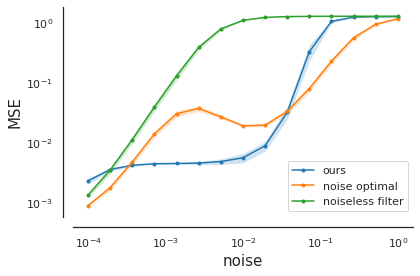

In [23]:
init_var = 0
dim = 10


time = np.arange(0, 3, 0.01)


ESS_errors = []
David_errors = []
NF_on_noisy_errors = []
ESS_STDs = []
David_STDs = []
NF_on_noisy_STDs = []

noises = np.logspace(np.log10(0.0001),np.log10(1),15)
# noises = [0.001]

for noise in noises:


    thetas = []
    thetas_opt = []
    P_series_s = []
    P_series_s_opt = []
    P_series_s_nf_on_noisy = []
    T_series_s = []
    # generate X_series and Y_series
    # X_series, Y_series, _, components = build_exp_series_too(a_s, e_s, noise=noise, time=time)
    # Y_series = Y_series[dim:]
    # X_series_nf = np.sum(components,axis=0)
    # Xhan = build_hankel(X_series, dim)
    # Xhan_nf = build_hankel(X_series_nf, dim)

    for itr in iterations:
        # build inital conditions by pertubing target inital conditions
        inits = np.tile(a_s, (num_init, 1)) 
        inits *= (1+init_var * np.random.randn(*inits.shape))

        # build training series with some random initial conditons and noise
        T_series = []
        # for i,init in enumerate(inits):
        t_series, _, _, comps = build_exp_series_too(inits[0], e_s, noise=noise, time=time)
        T_series = [t_series]
        T_series_s = [t_series]

        theta = learn_filter_from_inits(T_series, dim)
        theta_nf = learn_filter_from_inits([t_series_noise_free], dim)

        han = build_hankel(np.sum(comps, axis=0), dim)
        # compute coverances and avgerage
        X0 = han[:, :]
        Cxx = X0 @ X0.T 

        theta_opt = np.linalg.inv(Cxx + 25*noise**2*np.eye(dim))@Cxx@theta_nf


        # ALGO


        X_series, Y_series, _, components = build_exp_series_too(a_s, e_s, noise=noise, time=time)
        Y_series = Y_series[dim:]
        X_series_nf = np.sum(components,axis=0)
        t_series_noise_free = X_series_nf + 0.000001*np.random.randn(len(X_series_nf))
        Xhan = build_hankel(X_series, dim)
        Xhan_nf = build_hankel(X_series_nf, dim)


        P_series = theta.real @ Xhan
        P_series = solve_scale_shift(P_series, Y_series)
        # P_series *= np.sign(P_series[-1])*np.sign(Y_series)

        P_series_opt = theta_opt.real @ Xhan
        P_series_opt = solve_scale_shift(P_series_opt, Y_series)
        # P_series_opt *= np.sign(P_series_opt[-1])*np.sign(Y_series)

        P_series_nf = theta_nf.real @ Xhan_nf
        P_series_nf = solve_scale_shift(P_series_nf, Y_series)
        # P_series_nf *= np.sign(P_series_nf[-1])*np.sign(Y_series)

        P_series_nf_on_noisy = theta_nf.real @ Xhan
        P_series_nf_on_noisy = solve_scale_shift(P_series_nf_on_noisy, Y_series)
        # P_series_nf_on_noisy *= np.sign(P_series_nf_on_noisy[-1])*np.sign(Y_series)

        theta /= theta[-1]
        theta_opt /= theta_opt[-1]

        thetas.append(theta.real)
        thetas_opt.append(theta_opt.real)
        P_series_s.append(P_series)
        P_series_s_opt.append(P_series_opt)
        P_series_s_nf_on_noisy.append(P_series_nf_on_noisy)


    ESS = [np.mean((Y_series - p)**2) for p in P_series_s]
    David = [np.mean((Y_series - p)**2) for p in P_series_s_opt]
    nf_on_noisy = [np.mean((Y_series - p)**2) for p in P_series_s_nf_on_noisy]

    ESS_errors.append(np.mean(ESS))
    ESS_STDs.append(np.std(ESS))

    David_errors.append(np.mean(David))
    David_STDs.append(np.std(David))

    NF_on_noisy_errors.append(np.mean(nf_on_noisy))
    NF_on_noisy_STDs.append(np.std(nf_on_noisy))

    # print('ESS = ', np.mean(ESS), np.std(ESS))
    # print('David = ', np.mean(David), np.std(David))
    # print('NF_on_noisy = ', np.sum((Y_series - P_series_nf_on_noisy)**2))
    # print('NF_on_NF = ', np.sum((Y_series - P_series_nf)**2))

ESS_errors, ESS_STDs, David_errors, David_STDs, NF_on_noisy_errors, NF_on_noisy_STDs = (np.array(el) for el in [ESS_errors, ESS_STDs, David_errors, David_STDs, NF_on_noisy_errors, NF_on_noisy_STDs])

plt.plot(noises,ESS_errors,'.-',label='ours')
plt.fill_between(noises, ESS_errors-ESS_STDs, ESS_errors+ESS_STDs, alpha=0.2)
plt.plot(noises,David_errors,'.-', label='noise optimal')
plt.fill_between(noises, David_errors-David_STDs, David_errors+David_STDs, alpha=0.2)
plt.plot(noises,NF_on_noisy_errors,'.-', label='noiseless filter')
plt.fill_between(noises, NF_on_noisy_errors-NF_on_noisy_STDs, NF_on_noisy_errors+NF_on_noisy_STDs, alpha=0.2)
# plt.plot([noises[0],noises[-1]],[noises[0],noises[-1]], c='k', dashes=[15,9], lw=.3)
plt.legend(loc=4)

plt.xscale('log')
plt.yscale('log')


# plt.xticks(lag_i, ['$t - {}$'.format(abs(el)) for el in lag_i[:-1]]+['$t$'])
sns.despine(offset = 10)
plt.xlabel('noise', fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.tight_layout()
plt.savefig('comp2david.pdf')

plt.show()

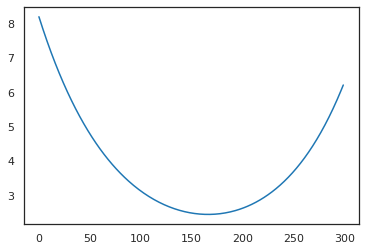

In [146]:
plt.plot(np.array(comps).sum(0))

In [147]:
noise*np.array(comps).sum(0)@np.random.randn(len(X_series_nf))

-48.97583140562378

In [148]:
len(X_series_nf)

300

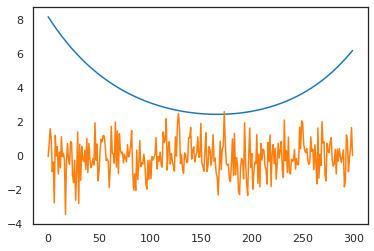

In [149]:
plt.plot(np.array(comps).sum(0))
plt.plot(noise*np.random.randn(len(X_series_nf)))

In [138]:
time

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
       1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 ,
       1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05, 2.1 , 2.15,
       2.2 , 2.25, 2.3 , 2.35, 2.4 , 2.45, 2.5 , 2.55, 2.6 , 2.65, 2.7 ,
       2.75, 2.8 , 2.85, 2.9 , 2.95])

In [169]:
ns = [2**n for n in range(8)]
runs = 1000
results = []
results_std = []
for n in ns:
    nums = []
    for run in range(runs):
        time = np.linspace(0, 3, n)
        # generate X_series and Y_series
        X_series, Y_series, _, components = build_exp_series_too(a_s, e_s, noise=noise, time=time)
        nums.append(np.array(components).sum(0)@np.random.randn(len(X_series)))
    results.append(np.mean(nums))
    results_std.append(np.std(nums))

plt.errorbar(ns, results, results_std)
plt.xscale('log')
plt.axhline(0, lw=1, c='k')

ns = [2**n for n in range(8)]
results = []
results_std = []
for n in ns:
    nums = []
    for run in range(runs):
        time = np.linspace(0, 3, n)
        # generate X_series and Y_series
        X_series, Y_series, _, components = build_exp_series_too(a_s, e_s, noise=noise, time=time)
        nums.append(np.mean(np.array(components).sum(0))*np.sum(np.random.randn(len(X_series))))
    results.append(np.mean(nums))
    results_std.append(np.std(nums))

plt.errorbar(np.array(ns)*1.1, results, results_std)

<ErrorbarContainer object of 3 artists>

In [165]:
np.mean(np.array(components).sum(0))

3.9077250664653054

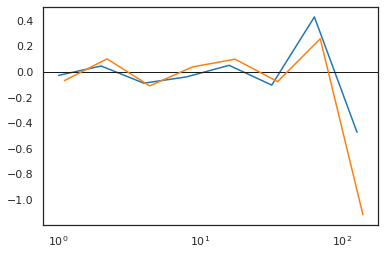

In [35]:
ns = [2**n for n in range(8)]
runs = 10000
results = []
results_std = []
for n in ns:
    nums = []
    for run in range(runs):
        time = np.linspace(0, 3, n)
        # generate X_series and Y_series
        X_series, Y_series, _, components = build_exp_series_too(a_s, e_s, noise=noise, time=time)
        nums.append(np.array(components).sum(0)@np.random.randn(len(X_series)))
    results.append(np.mean(nums))
    results_std.append(np.std(nums))

plt.plot(ns, results)
plt.xscale('log')
plt.axhline(0, lw=1, c='k')

ns = [2**n for n in range(8)]
results = []
results_std = []
for n in ns:
    nums = []
    for run in range(runs):
        time = np.linspace(0, 3, n)
        # generate X_series and Y_series
        X_series, Y_series, _, components = build_exp_series_too(a_s, e_s, noise=noise, time=time)
        nums.append(np.mean(np.array(components).sum(0))*np.sum(np.random.randn(len(X_series))))
    results.append(np.mean(nums))
    results_std.append(np.std(nums))

plt.plot(np.array(ns)*1.1, results)

In [33]:
results_std

[7.83264878549115,
 9.893211417649821,
 10.054328387322307,
 12.055914498003444,
 16.966433910468123,
 22.06709668314604,
 32.300412320763435,
 42.7707296861395]